In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from tqdm import tqdm_notebook


# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже)
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [2]:
batch_size = 64 # по какому количеству объектов выборки будем оценивать градиент 
anomaly_digit = 0 # какую цифру примем за аномалию

In [85]:
# Зададим обучающую и тестовую выборки в PyTorch

mnist_train = datasets.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = datasets.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

class AnomalyWrapper(torch.utils.data.Dataset):
    def __init__(self, mnist_set, anomaly_digit, num_anomalies=None):
        real = mnist_set.targets != anomaly_digit
        if not num_anomalies:
            num_anomalies = (~real).sum()
        self.data = torch.cat([mnist_set.data[real], mnist_set.data[~real][:num_anomalies]], dim=0).unsqueeze(1)
        self.target = torch.cat([torch.ones(len(real)), torch.zeros(num_anomalies)], dim=0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index].float()/255., self.target[index]
    
        


train_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_train, anomaly_digit),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_test, anomaly_digit),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)


get_dset = lambda x: torch.utils.data.DataLoader(AnomalyWrapper(mnist_train, anomaly_digit, x),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                drop_last=True)



Label: 1.0


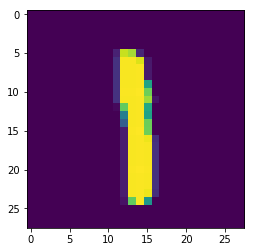

In [86]:
img, label = next(iter(train_loader)) # первый элемент обучающей выборки
print(f'Label: {label[0]}')
plt.imshow(img[0, 0,:,:])
plt.show()

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [63]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
# model = AlexNet(num_classes=1).cuda()

# criterion = nn.BCEWithLogitsLoss() 
# opt = torch.optim.Adam(model.parameters())


In [47]:
from sklearn.metrics import confusion_matrix

conf_metric = lambda labels, preds: confusion_matrix(labels, np.round(preds))

In [48]:
def train(loader):
    model.train()
    for j, (image,label) in tqdm_notebook(enumerate(loader), desc='train', leave=False):
        image, label = image.cuda(), label.cuda().float()
        opt.zero_grad()
        output = model(image).squeeze()
        loss = criterion(output, label)
        loss.backward()
        opt.step()

def evaluate(metric):
    model.eval()
    preds, labels = [], []
    for j, (image,label) in tqdm_notebook(enumerate(test_loader), desc='test', leave=False):
        image, label = image.cuda(), label.float()
        output = torch.sigmoid(model(image)).squeeze()
        preds.extend(output.detach().cpu().tolist())
        labels.extend(label.detach().tolist())
    return metric(labels, preds)

def train_eval(loader, num_epoch=10, metric=roc_auc_score):
    for epoch in range(num_epoch):
        train(loader)
    return evaluate(metric)



In [9]:
for num_anomalies in tqdm_notebook([10, 50, 100, 500, 1000, None]):
    dset = get_dset(num_anomalies)
    
    model = AlexNet(num_classes=1).cuda()

    criterion = nn.BCEWithLogitsLoss() 
    opt = torch.optim.Adam(model.parameters())

    metric = train_eval(dset, metric=conf_metric)
    print(f"Anomalies: {num_anomalies}, metric: \n{metric}")

Anomalies: 10, metric: 
[[ 294  682]
 [   0 9008]]


Anomalies: 50, metric: 
[[ 884   95]
 [   1 9004]]


Anomalies: 100, metric: 
[[ 786  192]
 [   0 9006]]


Anomalies: 500, metric: 
[[ 961   18]
 [   4 9001]]


Anomalies: 1000, metric: 
[[ 956   23]
 [   1 9004]]


Anomalies: None, metric: 
[[ 976    3]
 [  10 8995]]



In [10]:
for num_anomalies in tqdm_notebook([10, 50, 100, 500, 1000, None]):
    dset = get_dset(num_anomalies)
    
    model = AlexNet(num_classes=1).cuda()

    criterion = nn.BCEWithLogitsLoss() 
    opt = torch.optim.Adam(model.parameters())

    metric = train_eval(dset, metric=roc_auc_score)
    print(f"Anomalies: {num_anomalies}, metric: \n{metric}")

Anomalies: 10, metric: 
0.9860693667517592


Anomalies: 50, metric: 
0.9941510122485244


Anomalies: 100, metric: 
0.9907231806834526


Anomalies: 500, metric: 
0.9998347697043094


Anomalies: 1000, metric: 
0.9998542212485473


Anomalies: None, metric: 
0.9999819643949934



In [15]:
torch.sigmoid(torch.Tensor([-1]))

tensor([0.2689])

# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [87]:
# Generator receives random noise z and create 1x28x28 image

class Generator(nn.Module):
    def __init__(self, input_shape=128):
        super(Generator,self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_shape, 16*7*7)
        )
        
        self.layers = nn.Sequential(
            nn.Conv2d(16, 64, 3, padding=1), # 7x7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 14x14
            nn.Conv2d(64, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 28x28
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1), # 1x28x28
        )

    def forward(self,z):
        z = self.fc(z).view(z.shape[0], 16, 7, 7)
        z = self.layers(z)
        return z

In [88]:
# Discriminator receives 1x28x28 image and returns a float number 0~1


class Discriminator(nn.Module):
    def __init__(self, num_classes=1):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [89]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = Generator().cuda()
discriminator = Discriminator().cuda()

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

In [90]:
# loss function, optimizers, and labels for training

criterion = nn.BCEWithLogitsLoss()
gen_optim = torch.optim.Adam(generator.parameters())
dis_optim = torch.optim.Adam(discriminator.parameters())

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(2):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

In [91]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model not restored--------



0:0th iteration gen_loss: 0.47255608439445496 dis_loss: 1.4183924198150635
0:150th iteration gen_loss: 0.33972880244255066 dis_loss: 1.1038330793380737
0:300th iteration gen_loss: 0.3135142922401428 dis_loss: 1.113519549369812
0:450th iteration gen_loss: 0.31330302357673645 dis_loss: 1.0595585107803345
0:600th iteration gen_loss: 0.31326526403427124 dis_loss: 1.0447678565979004
0:750th iteration gen_loss: 0.41882041096687317 dis_loss: 1.0575085878372192
0:900th iteration gen_loss: 0.33304646611213684 dis_loss: 1.0473949909210205


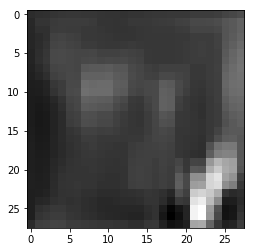

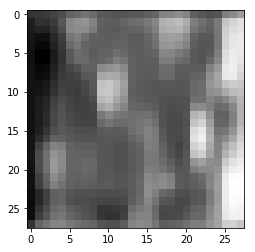

1:0th iteration gen_loss: 0.3319672644138336 dis_loss: 1.0491936206817627
1:150th iteration gen_loss: 0.41834360361099243 dis_loss: 1.0207844972610474
1:300th iteration gen_loss: 0.3159625232219696 dis_loss: 1.0504968166351318
1:450th iteration gen_loss: 0.3133470118045807 dis_loss: 1.0473382472991943
1:600th iteration gen_loss: 0.3145259618759155 dis_loss: 1.0340934991836548
1:750th iteration gen_loss: 0.31326642632484436 dis_loss: 1.0462373495101929
1:900th iteration gen_loss: 0.3134225308895111 dis_loss: 1.021016001701355


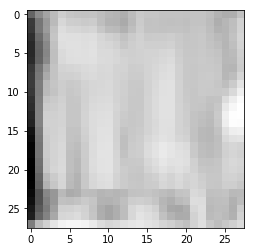

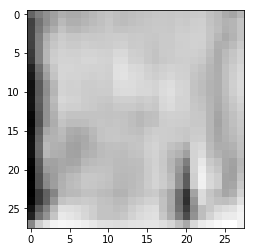

2:0th iteration gen_loss: 0.31384044885635376 dis_loss: 1.0331350564956665
2:150th iteration gen_loss: 0.31354308128356934 dis_loss: 1.0201843976974487
2:300th iteration gen_loss: 0.3132694363594055 dis_loss: 1.0389468669891357
2:450th iteration gen_loss: 0.31423020362854004 dis_loss: 1.0389546155929565
2:600th iteration gen_loss: 0.31326422095298767 dis_loss: 1.0334148406982422
2:750th iteration gen_loss: 0.3137218654155731 dis_loss: 1.014296293258667
2:900th iteration gen_loss: 0.3132633864879608 dis_loss: 1.0586875677108765


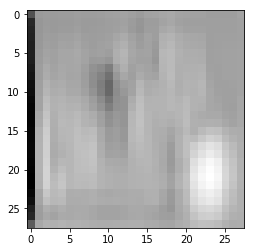

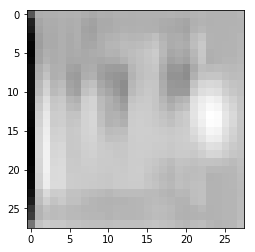

3:0th iteration gen_loss: 0.3141835927963257 dis_loss: 1.0271944999694824
3:150th iteration gen_loss: 0.3132633566856384 dis_loss: 1.0391550064086914
3:300th iteration gen_loss: 0.3132670521736145 dis_loss: 1.026350736618042
3:450th iteration gen_loss: 0.3132619559764862 dis_loss: 1.0264229774475098
3:600th iteration gen_loss: 0.31326520442962646 dis_loss: 1.040850043296814
3:750th iteration gen_loss: 0.3132646977901459 dis_loss: 1.0273160934448242
3:900th iteration gen_loss: 0.31326234340667725 dis_loss: 1.0201900005340576


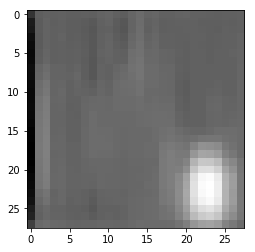

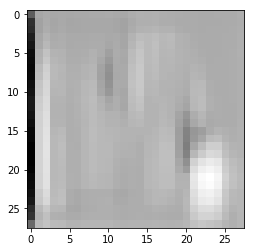

4:0th iteration gen_loss: 0.31326189637184143 dis_loss: 1.0207607746124268


In [ ]:
# train
num_epochs = 20

for epoch in range(num_epochs):
    for j, (image,label) in tqdm_notebook(enumerate(train_loader), leave=False):
        image = image.cuda()
        
        image = image[label == 1].cuda() # оставляем для обучения только нормальные объекты
        
        batch_size = image.shape[0]
        ones_label = torch.ones(batch_size, 1).cuda()
        zeros_label = torch.zeros(batch_size, 1).cuda()

        # generator
        generator.train()
        discriminator.eval()
        gen_optim.zero_grad()
        
        z = Variable(nn.init.normal_(torch.Tensor(batch_size, 128), mean=0, std=1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
    
        gen_loss = criterion(dis_fake, ones_label) # fake classified as real
        gen_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), 1)
        gen_optim.step()
    
        # discriminator

        generator.eval()
        discriminator.train()

        dis_optim.zero_grad()
        
        z = Variable(nn.init.normal_(torch.Tensor(batch_size, 128), mean=0, std=1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        dis_real = discriminator.forward(image)
        dis_loss = criterion(dis_fake, zeros_label) + criterion(dis_real, ones_label)
        dis_loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        dis_optim.step()
    
        # model save
        if j % 150 == 0:
#             torch.save(generator.state_dict(),'./saved_model/generator.pkl')
#             torch.save(discriminator.state_dict(),'./saved_model/discriminator.pkl')
            print(f"{epoch}:{j}th iteration gen_loss: {gen_loss.item()} dis_loss: {dis_loss.item()}")  
    image_check(gen_fake.cpu())
    

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$

In [13]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z,Lambda=0.1): # расстояние до аномалии x до ближайшего соседа G_z
    
    
    ,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z), dim=[1,2,3])
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature), 1)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

start_idx = 64
train_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit # 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

torch.Size([500, 1, 28, 28])

In [15]:
generator = nn.DataParallel(Generator(),device_ids=[0])
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])

#generator,discriminator

In [16]:
# !rm -rf saved_model/

In [17]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))

    print("\n--------model restored--------\n")

except:
    print("\n--------model not restored--------\n")
    pass




--------model restored--------



In [24]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake) # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([500])
tensor(23418.8535, device='cuda:0', grad_fn=<MeanBackward0>)


## Задание 4
Используя оптимизатор выше, найдите ближайших соседей z для выборки train_data_mnist. Посмотрите, как по мере обучения меняется расстояние и ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [19]:
for i in range(5000):
    gen_fake = generator(z.cuda())
    dist = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake,Lambda=0.01)
    dist.mean().backward() # минимизируем расстояние до нормального соседа
    z_optimizer.step() # обновляем ближайшего нормального соседа (z) для каждого объекта 
    roc_auc = roc_auc_score(train_label_mnist.detach().cpu().numpy(), 
                            dist.detach().cpu().numpy())
    if i%100==0:
        print(f'Dist: {dist.mean().cpu().data} ROC AUC: {roc_auc}')
        '''
        target = test_data_mnist[1,0,:,:].numpy()
        plt.imshow(target,cmap="gray")
        plt.show()
        
        img=gen_fake.cpu().data[1,0,:,:].numpy()
        plt.imshow(img,cmap='gray')
        plt.show()
        '''

Dist: 25619.994140625 ROC AUC: 0.8315818584070798


KeyboardInterrupt: 

## Задание 5
Посмотрим на ближайших соседей

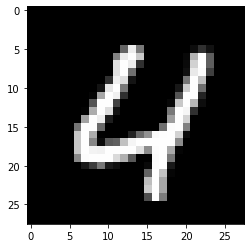

real data


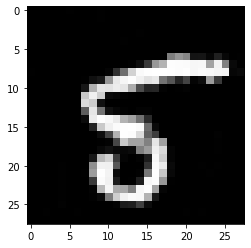

nearest neighbour

------------------------------------



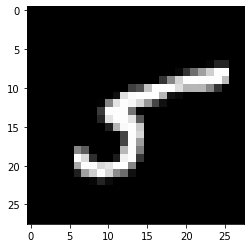

real data


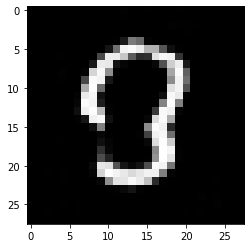

nearest neighbour

------------------------------------



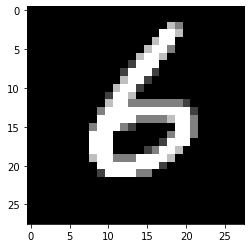

real data


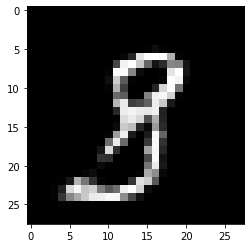

nearest neighbour

------------------------------------



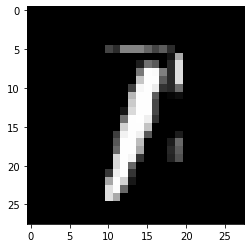

real data


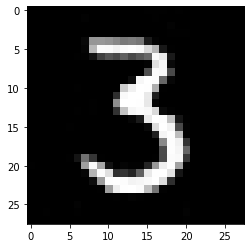

nearest neighbour

------------------------------------



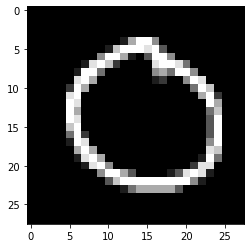

real data


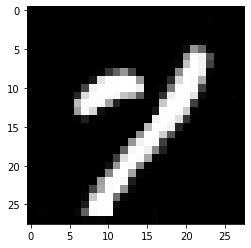

nearest neighbour

------------------------------------



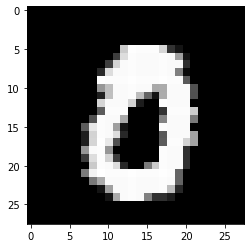

real data


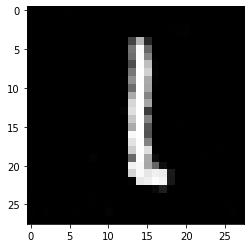

nearest neighbour

------------------------------------



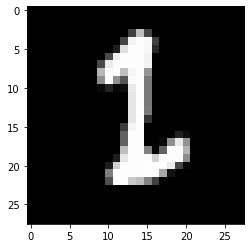

real data


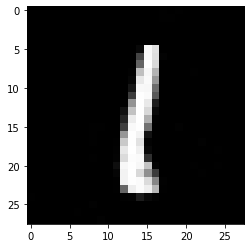

nearest neighbour

------------------------------------



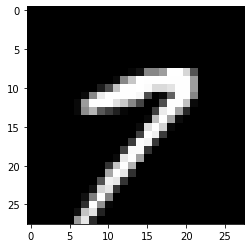

real data


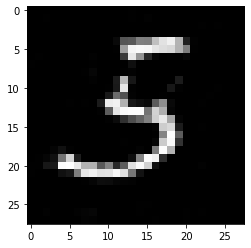

nearest neighbour

------------------------------------



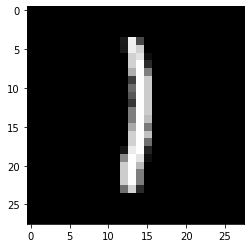

real data


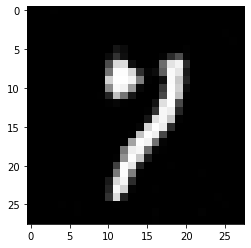

nearest neighbour

------------------------------------



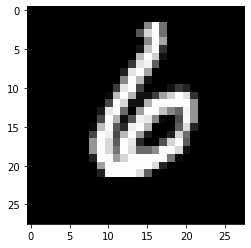

real data


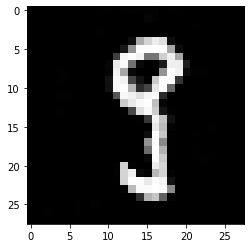

nearest neighbour

------------------------------------



In [22]:
for idx in range(10):
    target = train_data_mnist[idx,0,:,:].numpy()
    plt.imshow(target,cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:].numpy()
    plt.imshow(img,cmap='gray')
    plt.show()
    print("nearest neighbour")
    print("\n------------------------------------\n")

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

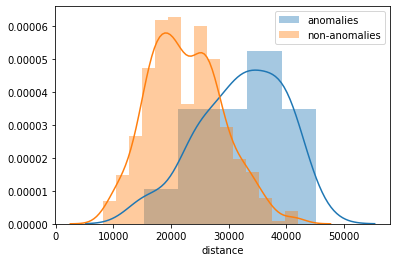

In [23]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

## Задание 7 (*)
Попробуйте обучить baseline (классификатор) на большем количестве аномалий. Стал ли классификатор работать лучше AnoGAN и, если да, с какого момента?